In [9]:
import pandas as pd
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

In [4]:
# Load csv file
df = pd.read_csv('data/etec_part1.csv')

In [5]:
# Filter only specific 'GR11' - Bergvärme
df_filtered = df[df['topic'] == 'ETEC/ETEC/114/WAGO_EDM/D1/GR11/W_TOT']

df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])
df_filtered = df_filtered.sort_values('timestamp')

/var/folders/gv/7bjgqyhj6td4g_cktv1tvblw0000gq/T/ipykernel_5707/3300239001.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])


In [6]:
df_filtered.head()

,_id,name,value,unit,timestamp,topic
1424856,65c4881c440168a5b71fe758,"750-495 Module: 3, Value ID: 1",14089.368,W,2024-02-08 08:51:19,ETEC/ETEC/114/WAGO_EDM/D1/GR11/W_TOT
1424859,65c4881c440168a5b71fe75b,"750-495 Module: 3, Value ID: 1",14101.618,W,2024-02-08 08:51:19,ETEC/ETEC/114/WAGO_EDM/D1/GR11/W_TOT
1424868,65c4881e440168a5b71fe764,"750-495 Module: 3, Value ID: 1",14083.068,W,2024-02-08 08:51:20,ETEC/ETEC/114/WAGO_EDM/D1/GR11/W_TOT
1424871,65c4881f440168a5b71fe767,"750-495 Module: 3, Value ID: 1",14114.601,W,2024-02-08 08:51:22,ETEC/ETEC/114/WAGO_EDM/D1/GR11/W_TOT
1424877,65c48821440168a5b71fe76d,"750-495 Module: 3, Value ID: 1",14117.868,W,2024-02-08 08:51:23,ETEC/ETEC/114/WAGO_EDM/D1/GR11/W_TOT


In [7]:
# Set 'timestamp' as index
df_filtered.set_index('timestamp', inplace=True)

Number of Unique Days: 7
Number of Unique Weeks: 2


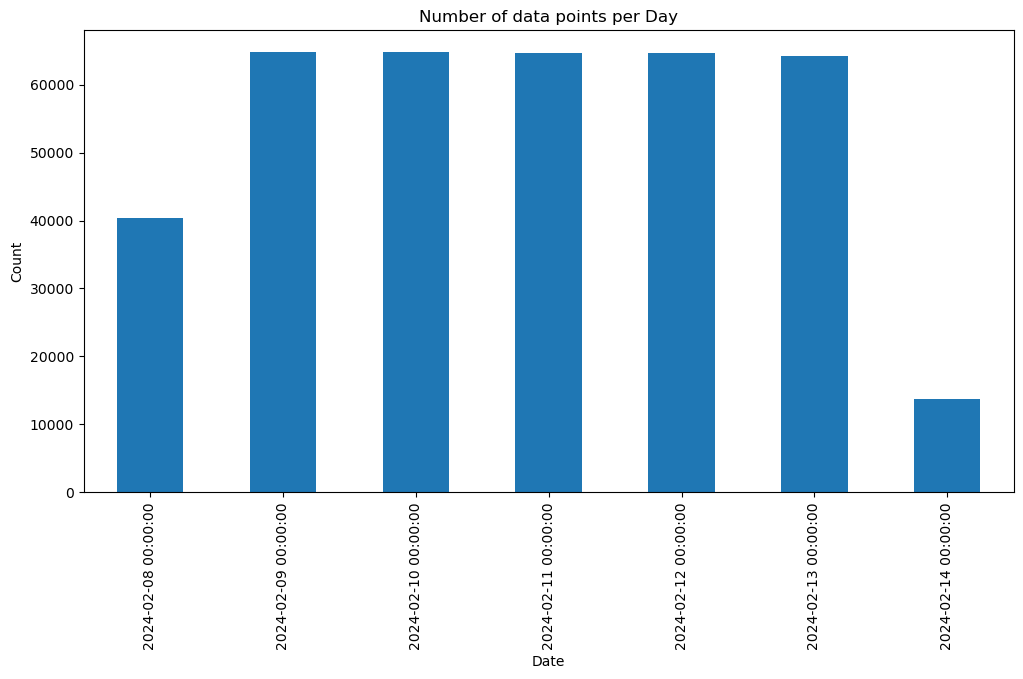

Text(0, 0.5, 'Count')

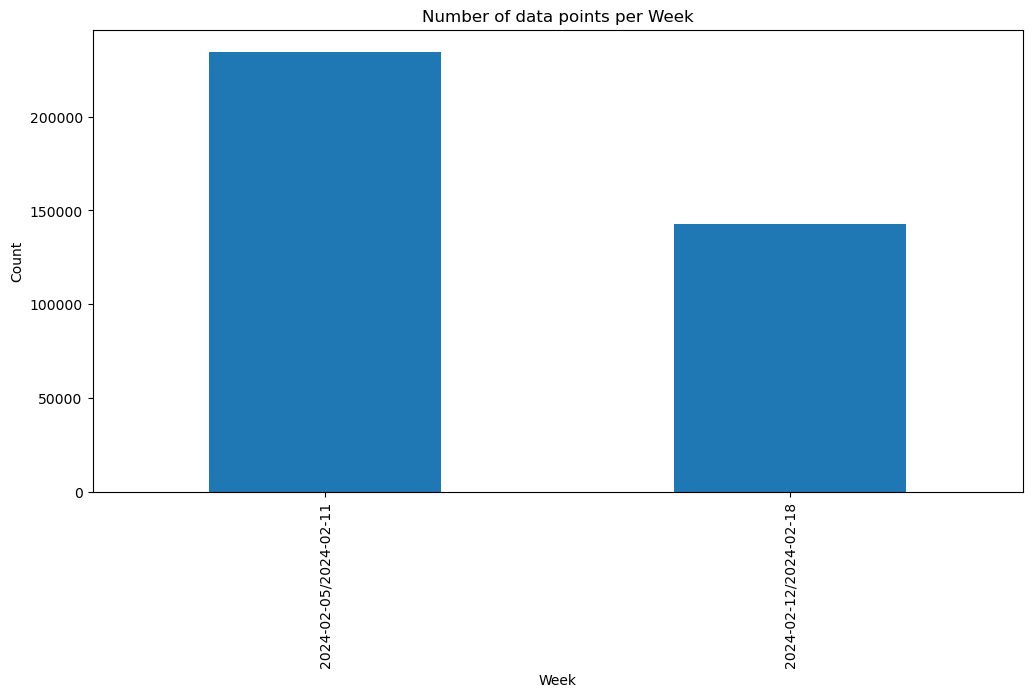

In [27]:
import matplotlib.pyplot as plt

# Create a separate column for date without time
df_filtered['date'] = pd.to_datetime(df_filtered.index.date)

# Count the number of unique days and weeks.
num_days = df_filtered['date'].nunique()
num_weeks = df_filtered['date'].dt.to_period('W').nunique()

print("Number of Unique Days:", num_days)
print("Number of Unique Weeks:", num_weeks)

# Visualize number of data points per day
df_filtered['date'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title('Number of data points per Day')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

# Visualize number of data points per week
df_filtered['date'].dt.to_period('W').value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.title('Number of data points per Week')
plt.xlabel('Week')
plt.ylabel('Count')

## Remove duplicates in timestamp by resampling

In [58]:
# Resample to every hour, taking mean of values if duplicates
y = df_filtered['value'].resample('30T').mean()

## Split data in train and test and create a forecasting horizon 

In [59]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

## Use Facebook Prophet model for time series forecasting

In [60]:
# Fit and predict
forecaster = Prophet(
    seasonality_mode="multiplicative",
    n_changepoints=int(len(y_train) / 8),
    add_country_holidays={"country_name": "Sweden"},
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
)

# Prophet requires a DataFrame with 'ds' and 'y', convert index to column then rename
df_prophet = y_train.reset_index().rename(columns={'timestamp':'ds', 'value':'y'})
forecaster.fit(df_prophet)
y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index

16:22:57 - cmdstanpy - INFO - Chain [1] start processing
16:22:57 - cmdstanpy - INFO - Chain [1] done processing
16:22:57 - cmdstanpy - INFO - Chain [1] start processing
16:22:57 - cmdstanpy - INFO - Chain [1] done processing


1.151904386045659

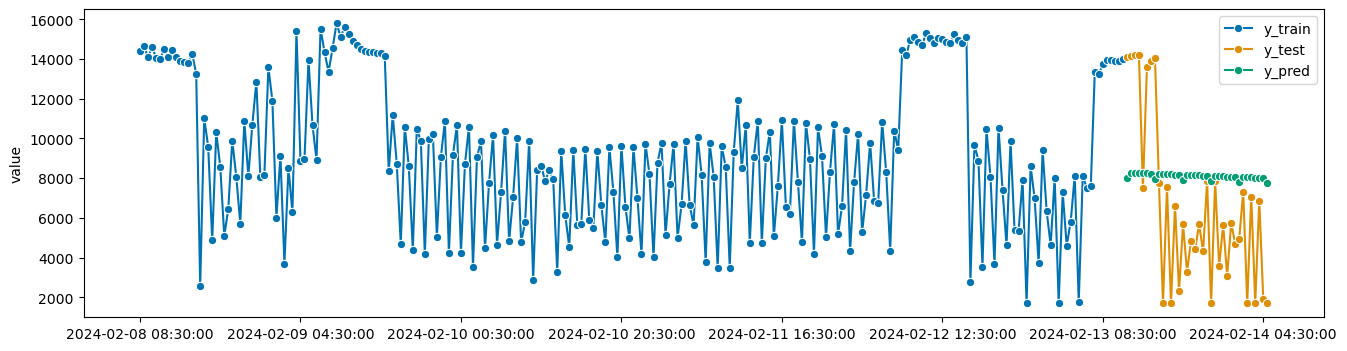

In [61]:
# Generate simple 1D forecast series
y_pred_simple = y_pred['y']

# Visualize
plot_series(y_train, y_test, y_pred_simple, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred_simple, symmetric=False)

MAPE:  0.47456928826359884


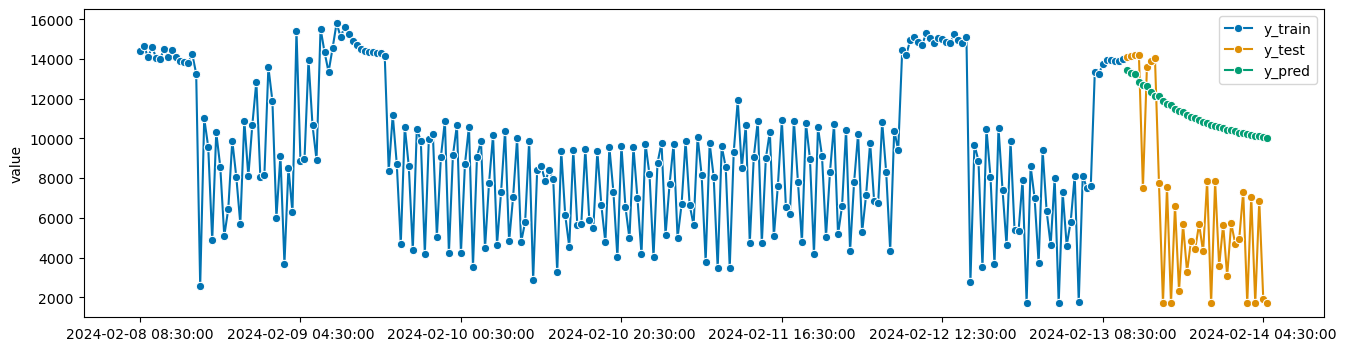

In [63]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

# Define the model
# In this case, let's use the AutoARIMA that will select the best ARIMA model
model = AutoARIMA(sp=12, suppress_warnings=True)

# Fit the model
model.fit(y_train)

# Define the forecasting horizon
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Predict
y_pred = model.predict(fh)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_pred, y_test)

# Print MAPE
print('MAPE: ', mape)

# Plot the series and the forecast
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()